# Inspection Notebook

In [41]:
from pynwb import NWBHDF5IO
import numpy as np
import matplotlib.pyplot as plt
import datajoint as dj
from pathlib import Path
import sys
import networkx as nx
import pandas as pd

dj_local_conf_path = "/Users/pauladkisson/Documents/CatalystNeuro/JadhavConv/jadhav-lab-to-nwb/src/jadhav_lab_to_nwb/spyglass_mock/dj_local_conf.json"
dj.config.load(dj_local_conf_path)  # load config for database connection info

# General Spyglass Imports
import spyglass.common as sgc  # this import connects to the database
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

# DLC Imports
from spyglass.position.v1.imported_pose import ImportedPose

# Custom Table Imports
sys.path.append(
    "/Users/pauladkisson/Documents/CatalystNeuro/JadhavConv/jadhav-lab-to-nwb/src/jadhav_lab_to_nwb/spyglass_extensions"
)
from task_leds import TaskLEDs

[2025-06-26 09:44:40,074][INFO]: DataJoint is configured from /Users/pauladkisson/Documents/CatalystNeuro/JadhavConv/jadhav-lab-to-nwb/src/jadhav_lab_to_nwb/spyglass_mock/dj_local_conf.json


This notebook inspects each of the 24 example sessions (12 pairs) for rivera_and_shukla_2025 conversion to ensure their quality.

In [42]:
sgc.Session()

[2025-06-26 09:44:43,789][WARNING]: Reconnecting to MySQL server.


nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
sub-XFN1_ses-07-15-2023-100_.nwb,XFN1,Brandeis University,Jadhav,07-15-2023-100,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 100% of the time when both rats poked the same well.,2023-07-15 00:00:00,2023-07-15 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."
sub-XFN1_ses-07-20-2023-100_.nwb,XFN1,Brandeis University,Jadhav,07-20-2023-100,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 100% of the time when both rats poked the same well.,2023-07-20 00:00:00,2023-07-20 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."
sub-XFN1_ses-07-27-2023-100_.nwb,XFN1,Brandeis University,Jadhav,07-27-2023-100,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 100% of the time when both rats poked the same well.,2023-07-27 00:00:00,2023-07-27 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."
sub-XFN1_ses-08-03-2023-50_.nwb,XFN1,Brandeis University,Jadhav,08-03-2023-50,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 50% of the time when both rats poked the same well.,2023-08-03 00:00:00,2023-08-03 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."
sub-XFN1_ses-08-07-2023-50_.nwb,XFN1,Brandeis University,Jadhav,08-07-2023-50,Rats performed a c

# Pair 1: XFN1-XFN3 07-15-2023-100

In [43]:
sgc.Session() & [{"subject_id": "XFN1", "session_id": "07-15-2023-100"}, {"subject_id": "XFN3", "session_id": "07-15-2023-100"}]

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
sub-XFN1_ses-07-15-2023-100_.nwb,XFN1,Brandeis University,Jadhav,07-15-2023-100,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 100% of the time when both rats poked the same well.,2023-07-15 00:00:00,2023-07-15 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."
sub-XFN3_ses-07-15-2023-100_.nwb,XFN3,Brandeis University,Jadhav,07-15-2023-100,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 100% of the time when both rats poked the same well.,2023-07-15 00:00:00,2023-07-15 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."


In [44]:
def plot_behavior(axs, matched_poke_A1, matched_poke_B2, matched_poke_C3, 
                  reward_well_1, reward_well_2, reward_well_3,
                  reward_well_A, reward_well_B, reward_well_C, rewarded_poke):
    
    # Plot matched pokes
    axs[0].stem(matched_poke_A1, np.ones_like(matched_poke_A1), linefmt='r-', markerfmt='ro', basefmt=' ', label='Matched Poke A1')
    axs[0].stem(matched_poke_B2, np.ones_like(matched_poke_B2)*1.2, linefmt='g-', markerfmt='go', basefmt=' ', label='Matched Poke B2')
    axs[0].stem(matched_poke_C3, np.ones_like(matched_poke_C3)*1.4, linefmt='b-', markerfmt='bo', basefmt=' ', label='Matched Poke C3')
    
    # Plot reward wells 1-3
    axs[1].stem(reward_well_1, np.ones_like(reward_well_1), linefmt='r-', markerfmt='rs', basefmt=' ', label='Reward Well 1')
    axs[1].stem(reward_well_2, np.ones_like(reward_well_2)*1.2, linefmt='g-', markerfmt='gs', basefmt=' ', label='Reward Well 2')
    axs[1].stem(reward_well_3, np.ones_like(reward_well_3)*1.4, linefmt='b-', markerfmt='bs', basefmt=' ', label='Reward Well 3')
    
    # Plot reward wells A-C
    axs[2].stem(reward_well_A, np.ones_like(reward_well_A), linefmt='r-', markerfmt='r^', basefmt=' ', label='Reward Well A')
    axs[2].stem(reward_well_B, np.ones_like(reward_well_B)*1.2, linefmt='g-', markerfmt='g^', basefmt=' ', label='Reward Well B')
    axs[2].stem(reward_well_C, np.ones_like(reward_well_C)*1.4, linefmt='b-', markerfmt='b^', basefmt=' ', label='Reward Well C')
    
    # Plot rewarded pokes
    axs[3].stem(rewarded_poke, np.ones_like(rewarded_poke), linefmt='k-', markerfmt='ko', basefmt=' ', label='Rewarded Poke')
    
    for i, ax in enumerate(axs):
        ax.set_ylim([0, 2])
        ax.set_yticks([])
        ax.legend(loc='upper right', fontsize='small')
    
    axs[-1].set_xlabel('Time (s)')
    axs[0].set_ylabel('Matched Pokes')
    axs[1].set_ylabel('Reward Wells 1-3')
    axs[2].set_ylabel('Reward Wells A-C')
    axs[3].set_ylabel('Rewarded Pokes')

In [45]:
def plot_pose_estimation(nodes, edges, name_to_data, node_to_name, timestamps):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Left plot: Average position scatter plot with trajectory
    all_x = np.array([name_to_data[node_to_name[node]][:, 0] for node in nodes])
    all_y = np.array([name_to_data[node_to_name[node]][:, 1] for node in nodes])

    x = np.nanmean(all_x, axis=0)
    y = np.nanmean(all_y, axis=0)

    sc = ax1.scatter(x, y, c=timestamps, cmap='viridis', s=1)
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.set_title('Average Position Trajectory')
    plt.colorbar(sc, ax=ax1, label='Time (s)')
    
    # Right plot: Network graph using networkx
    
    # Create a graph
    G = nx.Graph()
    
    # Add nodes
    for i, node in enumerate(nodes):
        G.add_node(i, label=node)
    
    # Add edges
    for edge in edges:
        G.add_edge(edge[0], edge[1])
    
    # Create layout
    pos = nx.spring_layout(G, seed=42)
    
    # Draw the network
    nx.draw(G, pos, ax=ax2, with_labels=True, 
            labels={i: nodes[i] for i in range(len(nodes))},
            node_color='lightblue', node_size=1000, 
            font_size=10, font_weight='bold',
            edge_color='gray', width=2)
    
    ax2.set_title('Pose Estimation Skeleton Structure')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

/opt/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.2.0 because version 0.1.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Data type,uint8
Shape,"(0, 0, 0)"
Array size,0.00 bytes
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,undefined
Data type,float64
Shape,"(42542,)"
Array size,332.36 KiB
Chunk shape,"(42542,)"


/opt/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.2.0 because version 0.1.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Data type,uint8
Shape,"(0, 0, 0)"
Array size,0.00 bytes
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,undefined
Data type,float64
Shape,"(42542,)"
Array size,332.36 KiB
Chunk shape,"(42542,)"


/var/folders/s3/qb42pmpn5jd0xb6fm2gt65qm0000gn/T/ipykernel_22160/1050502834.py:8: RuntimeWarning: Mean of empty slice
  x = np.nanmean(all_x, axis=0)
/var/folders/s3/qb42pmpn5jd0xb6fm2gt65qm0000gn/T/ipykernel_22160/1050502834.py:9: RuntimeWarning: Mean of empty slice
  y = np.nanmean(all_y, axis=0)


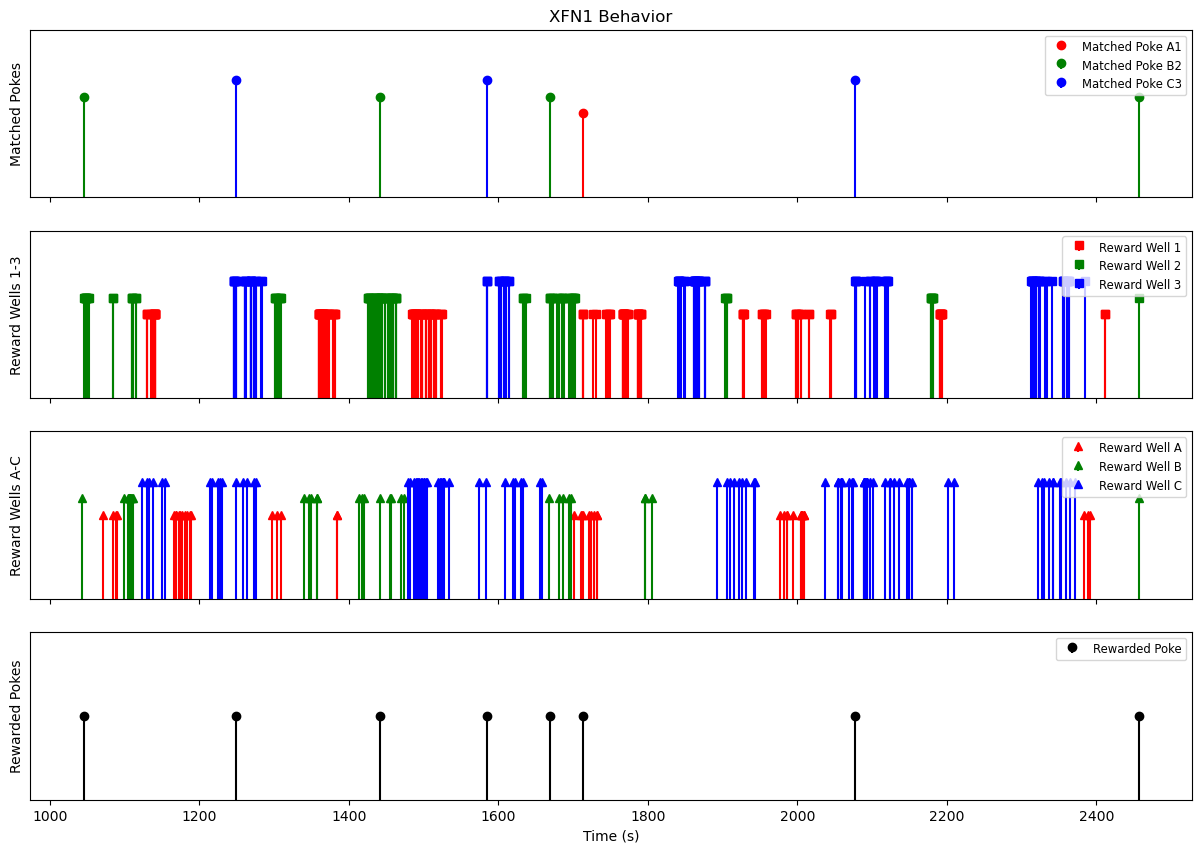

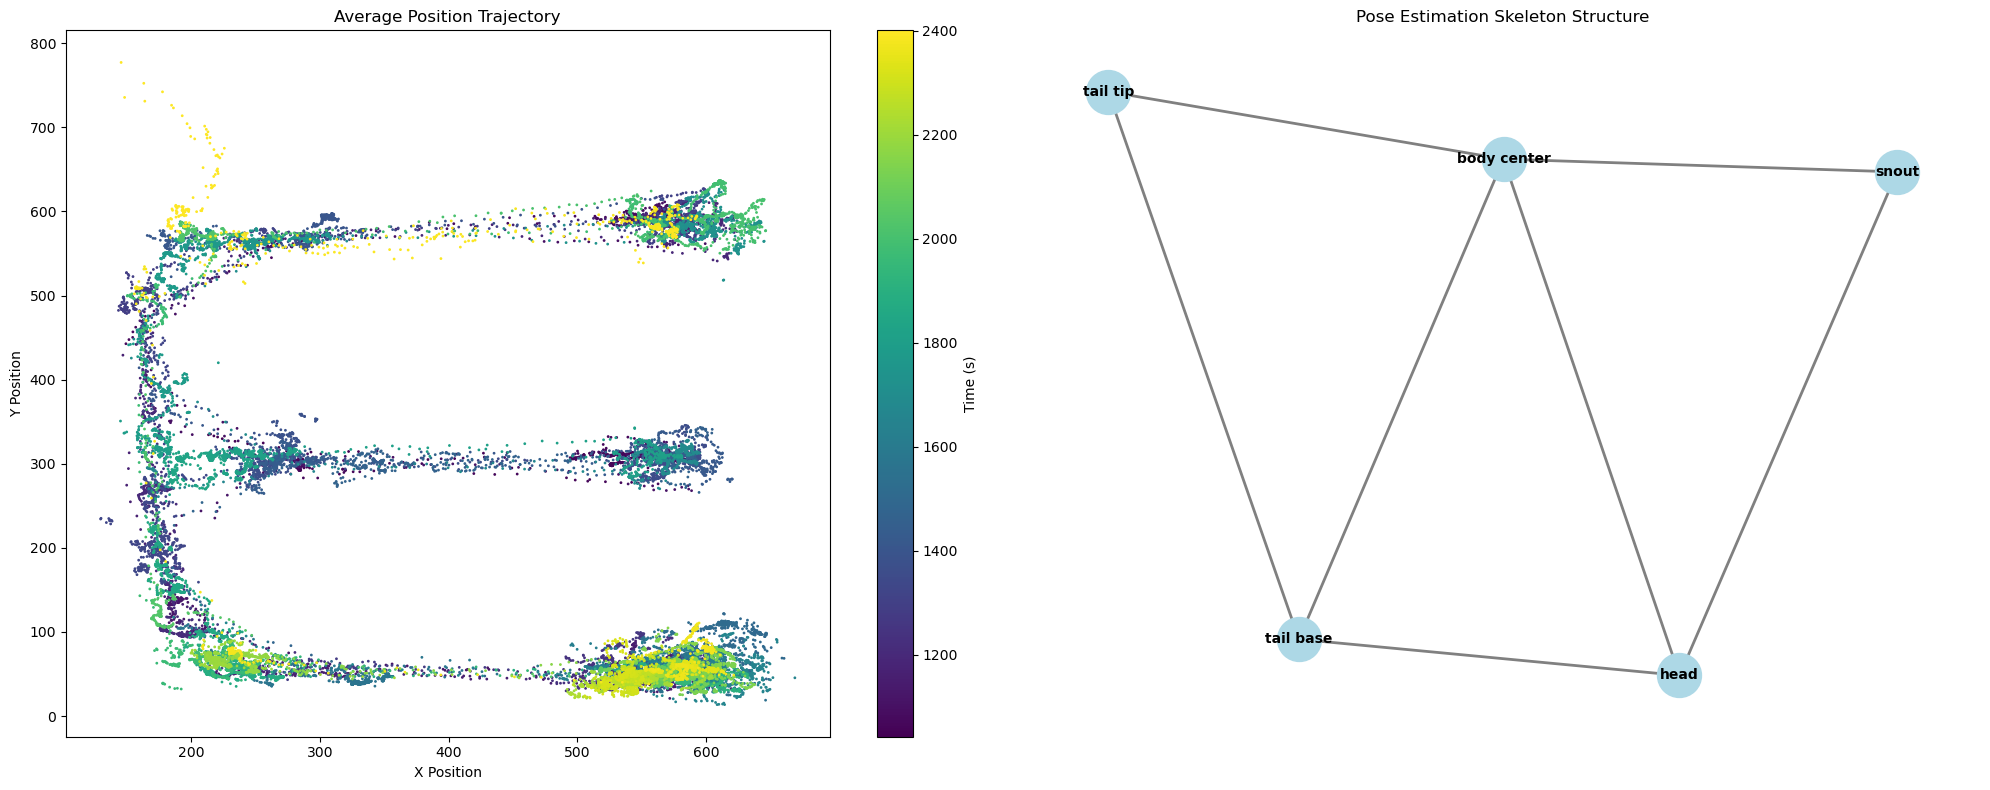

In [125]:
# XFN1
# Extract Data from NWB file
nwbfile_path = Path("/Volumes/T7/CatalystNeuro/Spyglass/raw/sub-XFN1_ses-07-15-2023-100.nwb")
with NWBHDF5IO(nwbfile_path, "r") as io:
    nwbfile = io.read()
    display(nwbfile)

    # Get Behavior
    matched_poke_A1_xfn1 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["matched_poke_A1"].timestamps[:]
    matched_poke_B2_xfn1 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["matched_poke_B2"].timestamps[:]
    matched_poke_C3_xfn1 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["matched_poke_C3"].timestamps[:]
    reward_well_1_xfn1 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["reward_well_1"].timestamps[:]
    reward_well_2_xfn1 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["reward_well_2"].timestamps[:]
    reward_well_3_xfn1 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["reward_well_3"].timestamps[:]
    reward_well_A_xfn1 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["reward_well_A"].timestamps[:]
    reward_well_B_xfn1 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["reward_well_B"].timestamps[:]
    reward_well_C_xfn1 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["reward_well_C"].timestamps[:]
    rewarded_poke_xfn1 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["rewarded_poke"].timestamps[:]

    # Get DLC
    nodes_sub_xfn1_data_xfn1 = nwbfile.processing["behavior"].data_interfaces["PoseEstimation_1-XFN1-1"].nodes[:]
    edges_sub_xfn1_data_xfn1 = nwbfile.processing["behavior"].data_interfaces["PoseEstimation_1-XFN1-1"].edges[:]
    pes_sub_xfn1_data_xfn1 = nwbfile.processing["behavior"].data_interfaces["PoseEstimation_1-XFN1-1"].pose_estimation_series
    name_to_data_sub_xfn1_data_xfn1 = {name: series.data[:] for name, series in pes_sub_xfn1_data_xfn1.items()}
    node_to_name_sub_xfn1_data_xfn1 = {node: f"PoseEstimationSeries{node.capitalize()}" for node in nodes_sub_xfn1_data_xfn1}
    pes_timestamps_sub_xfn1_data_xfn1 = pes_sub_xfn1_data_xfn1["PoseEstimationSeriesBody center"].timestamps[:]
    nodes_sub_xfn1_data_xfn3 = nwbfile.processing["behavior"].data_interfaces["PoseEstimation_1-XFN3-1"].nodes[:]
    edges_sub_xfn1_data_xfn3 = nwbfile.processing["behavior"].data_interfaces["PoseEstimation_1-XFN3-1"].edges[:]
    pes_sub_xfn1_data_xfn3 = nwbfile.processing["behavior"].data_interfaces["PoseEstimation_1-XFN3-1"].pose_estimation_series
    name_to_data_sub_xfn1_data_xfn3 = {name: series.data[:] for name, series in pes_sub_xfn1_data_xfn3.items()}
    node_to_name_sub_xfn1_data_xfn3 = {node: f"PoseEstimationSeries{node.capitalize()}" for node in nodes_sub_xfn1_data_xfn3}
    pes_timestamps_sub_xfn1_data_xfn3 = pes_sub_xfn1_data_xfn3["PoseEstimationSeriesBody center"].timestamps[:]

    # Get Video
    video_external_file_xfn1 = nwbfile.acquisition["Video_1-XFN1-XFN3"].external_file[:]
    video_timestamps_xfn1 = nwbfile.acquisition["Video_1-XFN1-XFN3"].timestamps[:]

    # Get Tables
    epochs_xfn1 = nwbfile.epochs.to_dataframe()
    tasks_xfn1 = nwbfile.processing["tasks"].data_interfaces["SocialW_Left"].to_dataframe()
    invalid_times_xfn1 = nwbfile.invalid_times.to_dataframe()


# Extract data from Spyglass Tables
nwb_copy_file_name = get_nwb_copy_filename(nwbfile_path.name)
# Get Behavior
matched_poke_A1_xfn1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "matched_poke_A1"}).fetch_nwb()[0]["dio"].timestamps[:]
matched_poke_B2_xfn1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "matched_poke_B2"}).fetch_nwb()[0]["dio"].timestamps[:]
matched_poke_C3_xfn1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "matched_poke_C3"}).fetch_nwb()[0]["dio"].timestamps[:]
reward_well_1_xfn1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "reward_well_1"}).fetch_nwb()[0]["dio"].timestamps[:]
reward_well_2_xfn1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "reward_well_2"}).fetch_nwb()[0]["dio"].timestamps[:]
reward_well_3_xfn1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "reward_well_3"}).fetch_nwb()[0]["dio"].timestamps[:]
reward_well_A_xfn1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "reward_well_A"}).fetch_nwb()[0]["dio"].timestamps[:]
reward_well_B_xfn1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "reward_well_B"}).fetch_nwb()[0]["dio"].timestamps[:]
reward_well_C_xfn1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "reward_well_C"}).fetch_nwb()[0]["dio"].timestamps[:]
rewarded_poke_xfn1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "rewarded_poke"}).fetch_nwb()[0]["dio"].timestamps[:]
# Get DLC
nodes_sub_xfn1_data_xfn1_spyglass = (ImportedPose & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": "pose_PoseEstimation_1-XFN1-1_valid_intervals"}).fetch_nwb()[0]["pose"].nodes[:]
edges_sub_xfn1_data_xfn1_spyglass = (ImportedPose & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": "pose_PoseEstimation_1-XFN1-1_valid_intervals"}).fetch_nwb()[0]["pose"].edges[:]
pes_sub_xfn1_data_xfn1_spyglass = (ImportedPose & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": "pose_PoseEstimation_1-XFN1-1_valid_intervals"}).fetch_nwb()[0]["pose"].pose_estimation_series
name_to_data_sub_xfn1_data_xfn1_spyglass = {name: series.data[:] for name, series in pes_sub_xfn1_data_xfn1_spyglass.items()}
pes_timestamps_sub_xfn1_data_xfn1_spyglass = pes_sub_xfn1_data_xfn1_spyglass["PoseEstimationSeriesBody center"].timestamps[:]
nodes_sub_xfn1_data_xfn3_spyglass = (ImportedPose & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": "pose_PoseEstimation_1-XFN3-1_valid_intervals"}).fetch_nwb()[0]["pose"].nodes[:]
edges_sub_xfn1_data_xfn3_spyglass = (ImportedPose & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": "pose_PoseEstimation_1-XFN3-1_valid_intervals"}).fetch_nwb()[0]["pose"].edges[:]
pes_sub_xfn1_data_xfn3_spyglass = (ImportedPose & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": "pose_PoseEstimation_1-XFN3-1_valid_intervals"}).fetch_nwb()[0]["pose"].pose_estimation_series
name_to_data_sub_xfn1_data_xfn3_spyglass = {name: series.data[:] for name, series in pes_sub_xfn1_data_xfn3_spyglass.items()}
pes_timestamps_sub_xfn1_data_xfn3_spyglass = pes_sub_xfn1_data_xfn3_spyglass["PoseEstimationSeriesBody center"].timestamps[:]
# Get Video
image_series = (sgc.VideoFile & {"nwb_file_name": nwb_copy_file_name, "epoch": 1}).fetch_nwb()[0]["video_file"]
video_external_file_xfn1_spyglass = image_series.external_file[:]
video_timestamps_xfn1_spyglass = image_series.timestamps[:]
# Get Tables
epochs_xfn1_spyglass = []
for i, row in epochs_xfn1.iterrows():
    interval_list_name = row["tags"][0]
    df = pd.DataFrame((sgc.IntervalList & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": interval_list_name}).fetch())
    epochs_xfn1_spyglass.append(df)
epochs_xfn1_spyglass = pd.concat(epochs_xfn1_spyglass, ignore_index=True)
task_epochs_xfn1_spyglass = []
for epoch in tasks_xfn1.task_epochs[0]:
    df = pd.DataFrame((sgc.TaskEpoch & {"nwb_file_name": nwb_copy_file_name, "epoch": epoch}).fetch())
    task_epochs_xfn1_spyglass.append(df)
task_epochs_xfn1_spyglass = pd.concat(task_epochs_xfn1_spyglass, ignore_index=True)
invalid_times_xfn1_spyglass = []
for i, row in invalid_times_xfn1.iterrows():
    interval_list_name = f"{row['tag']}_invalid_intervals"
    df = pd.DataFrame((sgc.IntervalList & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": interval_list_name}).fetch())
    invalid_times_xfn1_spyglass.append(df)
invalid_times_xfn1_spyglass = pd.concat(invalid_times_xfn1_spyglass, ignore_index=True)

# XFN3
# Extract Data from NWB file
nwbfile_path = Path("/Volumes/T7/CatalystNeuro/Spyglass/raw/sub-XFN3_ses-07-15-2023-100.nwb")
with NWBHDF5IO(nwbfile_path, "r") as io:
    nwbfile = io.read()
    display(nwbfile)

    # Get Behavior
    matched_poke_A1_xfn3 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["matched_poke_A1"].timestamps[:]
    matched_poke_B2_xfn3 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["matched_poke_B2"].timestamps[:]
    matched_poke_C3_xfn3 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["matched_poke_C3"].timestamps[:]
    reward_well_1_xfn3 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["reward_well_1"].timestamps[:]
    reward_well_2_xfn3 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["reward_well_2"].timestamps[:]
    reward_well_3_xfn3 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["reward_well_3"].timestamps[:]
    reward_well_A_xfn3 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["reward_well_A"].timestamps[:]
    reward_well_B_xfn3 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["reward_well_B"].timestamps[:]
    reward_well_C_xfn3 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["reward_well_C"].timestamps[:]
    rewarded_poke_xfn3 = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series["rewarded_poke"].timestamps[:]

    # Get DLC
    nodes_sub_xfn3_data_xfn1 = nwbfile.processing["behavior"].data_interfaces["PoseEstimation_1-XFN1-1"].nodes[:]
    edges_sub_xfn3_data_xfn1 = nwbfile.processing["behavior"].data_interfaces["PoseEstimation_1-XFN1-1"].edges[:]
    pes_sub_xfn3_data_xfn1 = nwbfile.processing["behavior"].data_interfaces["PoseEstimation_1-XFN1-1"].pose_estimation_series
    name_to_data_sub_xfn3_data_xfn1 = {name: series.data[:] for name, series in pes_sub_xfn3_data_xfn1.items()}
    node_to_name_sub_xfn3_data_xfn1 = {node: f"PoseEstimationSeries{node.capitalize()}" for node in nodes_sub_xfn3_data_xfn1}
    pes_timestamps_sub_xfn3_data_xfn1 = pes_sub_xfn3_data_xfn1["PoseEstimationSeriesBody center"].timestamps[:]
    nodes_sub_xfn3_data_xfn3 = nwbfile.processing["behavior"].data_interfaces["PoseEstimation_1-XFN3-1"].nodes[:]
    edges_sub_xfn3_data_xfn3 = nwbfile.processing["behavior"].data_interfaces["PoseEstimation_1-XFN3-1"].edges[:]
    pes_sub_xfn3_data_xfn3 = nwbfile.processing["behavior"].data_interfaces["PoseEstimation_1-XFN3-1"].pose_estimation_series
    name_to_data_sub_xfn3_data_xfn3 = {name: series.data[:] for name, series in pes_sub_xfn3_data_xfn3.items()}
    node_to_name_sub_xfn3_data_xfn3 = {node: f"PoseEstimationSeries{node.capitalize()}" for node in nodes_sub_xfn3_data_xfn3}
    pes_timestamps_sub_xfn3_data_xfn3 = pes_sub_xfn3_data_xfn3["PoseEstimationSeriesBody center"].timestamps[:]

    # Get Video
    video_external_file_xfn3 = nwbfile.acquisition["Video_1-XFN1-XFN3"].external_file[:]
    video_timestamps_xfn3 = nwbfile.acquisition["Video_1-XFN1-XFN3"].timestamps[:]

    # Get Tables
    epochs_xfn3 = nwbfile.epochs.to_dataframe()
    tasks_xfn3 = nwbfile.processing["tasks"].data_interfaces["SocialW_Right"].to_dataframe()
    invalid_times_xfn3 = nwbfile.invalid_times.to_dataframe()


# Extract data from Spyglass Tables
nwb_copy_file_name = get_nwb_copy_filename(nwbfile_path.name)
# Get Behavior
matched_poke_A1_xfn3_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "matched_poke_A1"}).fetch_nwb()[0]["dio"].timestamps[:]
matched_poke_B2_xfn3_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "matched_poke_B2"}).fetch_nwb()[0]["dio"].timestamps[:]
matched_poke_C3_xfn3_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "matched_poke_C3"}).fetch_nwb()[0]["dio"].timestamps[:]
reward_well_1_xfn3_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "reward_well_1"}).fetch_nwb()[0]["dio"].timestamps[:]
reward_well_2_xfn3_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "reward_well_2"}).fetch_nwb()[0]["dio"].timestamps[:]
reward_well_3_xfn3_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "reward_well_3"}).fetch_nwb()[0]["dio"].timestamps[:]
reward_well_A_xfn3_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "reward_well_A"}).fetch_nwb()[0]["dio"].timestamps[:]
reward_well_B_xfn3_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "reward_well_B"}).fetch_nwb()[0]["dio"].timestamps[:]
reward_well_C_xfn3_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "reward_well_C"}).fetch_nwb()[0]["dio"].timestamps[:]
rewarded_poke_xfn3_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name, "dio_event_name": "rewarded_poke"}).fetch_nwb()[0]["dio"].timestamps[:]
# Get DLC
nodes_sub_xfn3_data_xfn1_spyglass = (ImportedPose & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": "pose_PoseEstimation_1-XFN1-1_valid_intervals"}).fetch_nwb()[0]["pose"].nodes[:]
edges_sub_xfn3_data_xfn1_spyglass = (ImportedPose & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": "pose_PoseEstimation_1-XFN1-1_valid_intervals"}).fetch_nwb()[0]["pose"].edges[:]
pes_sub_xfn3_data_xfn1_spyglass = (ImportedPose & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": "pose_PoseEstimation_1-XFN1-1_valid_intervals"}).fetch_nwb()[0]["pose"].pose_estimation_series
name_to_data_sub_xfn3_data_xfn1_spyglass = {name: series.data[:] for name, series in pes_sub_xfn3_data_xfn1_spyglass.items()}
pes_timestamps_sub_xfn3_data_xfn1_spyglass = pes_sub_xfn3_data_xfn1_spyglass["PoseEstimationSeriesBody center"].timestamps[:]
nodes_sub_xfn3_data_xfn3_spyglass = (ImportedPose & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": "pose_PoseEstimation_1-XFN3-1_valid_intervals"}).fetch_nwb()[0]["pose"].nodes[:]
edges_sub_xfn3_data_xfn3_spyglass = (ImportedPose & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": "pose_PoseEstimation_1-XFN3-1_valid_intervals"}).fetch_nwb()[0]["pose"].edges[:]
pes_sub_xfn3_data_xfn3_spyglass = (ImportedPose & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": "pose_PoseEstimation_1-XFN3-1_valid_intervals"}).fetch_nwb()[0]["pose"].pose_estimation_series
name_to_data_sub_xfn3_data_xfn3_spyglass = {name: series.data[:] for name, series in pes_sub_xfn3_data_xfn3_spyglass.items()}
pes_timestamps_sub_xfn3_data_xfn3_spyglass = pes_sub_xfn3_data_xfn3_spyglass["PoseEstimationSeriesBody center"].timestamps[:]
# Get Video
image_series = (sgc.VideoFile & {"nwb_file_name": nwb_copy_file_name, "epoch": 1}).fetch_nwb()[0]["video_file"]
video_external_file_xfn3_spyglass = image_series.external_file[:]
video_timestamps_xfn3_spyglass = image_series.timestamps[:]
# Get Tables
epochs_xfn3_spyglass = []
for i, row in epochs_xfn3.iterrows():
    interval_list_name = row["tags"][0]
    df = pd.DataFrame((sgc.IntervalList & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": interval_list_name}).fetch())
    epochs_xfn3_spyglass.append(df)
epochs_xfn3_spyglass = pd.concat(epochs_xfn3_spyglass, ignore_index=True)
task_epochs_xfn3_spyglass = []
for epoch in tasks_xfn3.task_epochs[0]:
    df = pd.DataFrame((sgc.TaskEpoch & {"nwb_file_name": nwb_copy_file_name, "epoch": epoch}).fetch())
    task_epochs_xfn3_spyglass.append(df)
task_epochs_xfn3_spyglass = pd.concat(task_epochs_xfn3_spyglass, ignore_index=True)
invalid_times_xfn3_spyglass = []
for i, row in invalid_times_xfn3.iterrows():
    interval_list_name = f"{row['tag']}_invalid_intervals"
    df = pd.DataFrame((sgc.IntervalList & {"nwb_file_name": nwb_copy_file_name, "interval_list_name": interval_list_name}).fetch())
    invalid_times_xfn3_spyglass.append(df)
invalid_times_xfn3_spyglass = pd.concat(invalid_times_xfn3_spyglass, ignore_index=True)


# Assertions
# Check consistency within XFN1 data
tolerance = 5.0  # seconds
for timestamp in matched_poke_A1_xfn1:
    assert np.any(np.abs(reward_well_1_xfn1 - timestamp) <= tolerance), f"Matched poke A1 timestamp {timestamp} not found within {tolerance}s in reward well 1"
    assert np.any(np.abs(reward_well_A_xfn1 - timestamp) <= tolerance), f"Matched poke A1 timestamp {timestamp} not found within {tolerance}s in reward well A"
for timestamp in matched_poke_B2_xfn1:
    assert np.any(np.abs(reward_well_2_xfn1 - timestamp) <= tolerance), f"Matched poke B2 timestamp {timestamp} not found within {tolerance}s in reward well 2"
    assert np.any(np.abs(reward_well_B_xfn1 - timestamp) <= tolerance), f"Matched poke B2 timestamp {timestamp} not found within {tolerance}s in reward well B"
for timestamp in matched_poke_C3_xfn1:
    assert np.any(np.abs(reward_well_3_xfn1 - timestamp) <= tolerance), f"Matched poke C3 timestamp {timestamp} not found within {tolerance}s in reward well 3"
    assert np.any(np.abs(reward_well_C_xfn1 - timestamp) <= tolerance), f"Matched poke C3 timestamp {timestamp} not found within {tolerance}s in reward well C"
all_matched_pokes = np.sort(np.concatenate((matched_poke_A1_xfn1, matched_poke_B2_xfn1, matched_poke_C3_xfn1)))
np.testing.assert_array_equal(rewarded_poke_xfn1, all_matched_pokes, "Rewarded poke timestamps do not match all matched pokes in XFN1")
np.testing.assert_array_equal(video_timestamps_xfn1[:len(pes_timestamps_sub_xfn1_data_xfn1)], pes_timestamps_sub_xfn1_data_xfn1, "Video timestamps do not match DLC timestamps in XFN1")

# Check consistency with XFN3 data
# Behavior
np.testing.assert_array_equal(matched_poke_A1_xfn1, matched_poke_A1_xfn3, "Matched poke A1 timestamps differ between XFN1 and XFN3")
np.testing.assert_array_equal(matched_poke_B2_xfn1, matched_poke_B2_xfn3, "Matched poke B2 timestamps differ between XFN1 and XFN3")
np.testing.assert_array_equal(matched_poke_C3_xfn1, matched_poke_C3_xfn3, "Matched poke C3 timestamps differ between XFN1 and XFN3")
np.testing.assert_array_equal(reward_well_1_xfn1, reward_well_1_xfn3, "Reward well 1 timestamps differ between XFN1 and XFN3")
np.testing.assert_array_equal(reward_well_2_xfn1, reward_well_2_xfn3, "Reward well 2 timestamps differ between XFN1 and XFN3")
np.testing.assert_array_equal(reward_well_3_xfn1, reward_well_3_xfn3, "Reward well 3 timestamps differ between XFN1 and XFN3")
np.testing.assert_array_equal(reward_well_A_xfn1, reward_well_A_xfn3, "Reward well A timestamps differ between XFN1 and XFN3")
np.testing.assert_array_equal(reward_well_B_xfn1, reward_well_B_xfn3, "Reward well B timestamps differ between XFN1 and XFN3")
np.testing.assert_array_equal(reward_well_C_xfn1, reward_well_C_xfn3, "Reward well C timestamps differ between XFN1 and XFN3")
np.testing.assert_array_equal(rewarded_poke_xfn1, rewarded_poke_xfn3, "Rewarded poke timestamps differ between XFN1 and XFN3")
# DLC
np.testing.assert_array_equal(nodes_sub_xfn1_data_xfn1, nodes_sub_xfn3_data_xfn1, "DLC nodes differ between XFN1 and XFN3 for XFN1 data")
np.testing.assert_array_equal(edges_sub_xfn1_data_xfn1, edges_sub_xfn3_data_xfn1, "DLC edges differ between XFN1 and XFN3 for XFN1 data")
for name, data in name_to_data_sub_xfn1_data_xfn1.items():
    np.testing.assert_array_equal(data, name_to_data_sub_xfn3_data_xfn1[name], f"DLC data for {name} differs between XFN1 and XFN3 for XFN1 data")
np.testing.assert_array_equal(pes_timestamps_sub_xfn1_data_xfn1, pes_timestamps_sub_xfn3_data_xfn1, "DLC timestamps differ between XFN1 and XFN3 for XFN1 data")
np.testing.assert_array_equal(nodes_sub_xfn1_data_xfn3, nodes_sub_xfn3_data_xfn3, "DLC nodes differ between XFN1 and XFN3 for XFN3 data")
np.testing.assert_array_equal(edges_sub_xfn1_data_xfn3, edges_sub_xfn3_data_xfn3, "DLC edges differ between XFN1 and XFN3 for XFN3 data")
for name, data in name_to_data_sub_xfn1_data_xfn3.items():
    np.testing.assert_array_equal(data, name_to_data_sub_xfn3_data_xfn3[name], f"DLC data for {name} differs between XFN1 and XFN3 for XFN3 data")
np.testing.assert_array_equal(pes_timestamps_sub_xfn1_data_xfn3, pes_timestamps_sub_xfn3_data_xfn3, "DLC timestamps differ between XFN1 and XFN3 for XFN3 data")
# Video
np.testing.assert_array_equal(video_external_file_xfn1, video_external_file_xfn3, "Video external files differ between XFN1 and XFN3")
np.testing.assert_array_equal(video_timestamps_xfn1, video_timestamps_xfn3, "Video timestamps differ between XFN1 and XFN3")

# Check consistency between original NWB and Spyglass data for XFN1
# Behavior
np.testing.assert_array_equal(matched_poke_A1_xfn1, matched_poke_A1_xfn1_spyglass, "Matched poke A1 timestamps differ between original NWB and Spyglass for XFN1")
np.testing.assert_array_equal(matched_poke_B2_xfn1, matched_poke_B2_xfn1_spyglass, "Matched poke B2 timestamps differ between original NWB and Spyglass for XFN1")
np.testing.assert_array_equal(matched_poke_C3_xfn1, matched_poke_C3_xfn1_spyglass, "Matched poke C3 timestamps differ between original NWB and Spyglass for XFN1")
np.testing.assert_array_equal(reward_well_1_xfn1, reward_well_1_xfn1_spyglass, "Reward well 1 timestamps differ between original NWB and Spyglass for XFN1")
np.testing.assert_array_equal(reward_well_2_xfn1, reward_well_2_xfn1_spyglass, "Reward well 2 timestamps differ between original NWB and Spyglass for XFN1")
np.testing.assert_array_equal(reward_well_3_xfn1, reward_well_3_xfn1_spyglass, "Reward well 3 timestamps differ between original NWB and Spyglass for XFN1")
np.testing.assert_array_equal(reward_well_A_xfn1, reward_well_A_xfn1_spyglass, "Reward well A timestamps differ between original NWB and Spyglass for XFN1")
np.testing.assert_array_equal(reward_well_B_xfn1, reward_well_B_xfn1_spyglass, "Reward well B timestamps differ between original NWB and Spyglass for XFN1")
np.testing.assert_array_equal(reward_well_C_xfn1, reward_well_C_xfn1_spyglass, "Reward well C timestamps differ between original NWB and Spyglass for XFN1")
np.testing.assert_array_equal(rewarded_poke_xfn1, rewarded_poke_xfn1_spyglass, "Rewarded poke timestamps differ between original NWB and Spyglass for XFN1")
# DLC
np.testing.assert_array_equal(nodes_sub_xfn1_data_xfn1, nodes_sub_xfn1_data_xfn1_spyglass, "DLC nodes differ between original NWB and Spyglass for XFN1")
np.testing.assert_array_equal(edges_sub_xfn1_data_xfn1, edges_sub_xfn1_data_xfn1_spyglass, "DLC edges differ between original NWB and Spyglass for XFN1")
for name, data in name_to_data_sub_xfn1_data_xfn1_spyglass.items():
    np.testing.assert_array_equal(data, name_to_data_sub_xfn1_data_xfn1[name], f"DLC data for {name} differs between original NWB and Spyglass for XFN1")
np.testing.assert_array_equal(pes_timestamps_sub_xfn1_data_xfn1, pes_timestamps_sub_xfn1_data_xfn1_spyglass, "DLC timestamps differ between original NWB and Spyglass for XFN1")
# Video
np.testing.assert_array_equal(video_external_file_xfn1, video_external_file_xfn1_spyglass, "Video external files differ between original NWB and Spyglass for XFN1")
np.testing.assert_array_equal(video_timestamps_xfn1, video_timestamps_xfn1_spyglass, "Video timestamps differ between original NWB and Spyglass for XFN1")
# Tables
# Epochs
for i, row in epochs_xfn1.iterrows():
    row_spyglass = epochs_xfn1_spyglass.iloc[i]
    start_time = row["start_time"]
    stop_time = row["stop_time"]
    start_time_spyglass = row_spyglass["valid_times"][0][0]
    stop_time_spyglass = row_spyglass["valid_times"][0][1]
    assert start_time == start_time_spyglass, f"Epoch {i} start time differs between original NWB and Spyglass for XFN1"
    assert stop_time == stop_time_spyglass, f"Epoch {i} stop time differs between original NWB and Spyglass for XFN1"
# Tasks
row = tasks_xfn1.iloc[0]
task_name = row["task_name"]
task_environment = row["task_environment"]
for i, row in task_epochs_xfn1_spyglass.iterrows():
    task_name_spyglass = row["task_name"]
    task_environment_spyglass = row["task_environment"]
    assert task_name == task_name_spyglass, f"Task epoch {i} task name differs between original NWB and Spyglass for XFN1"
    assert task_environment == task_environment_spyglass, f"Task epoch {i} task environment differs between original NWB and Spyglass for XFN1"
# Invalid Times
for i, row in invalid_times_xfn1.iterrows():
    row_spyglass = invalid_times_xfn1_spyglass.iloc[i]
    start_time = row["start_time"]
    stop_time = row["stop_time"]
    start_time_spyglass = row_spyglass["valid_times"][0][0]
    stop_time_spyglass = row_spyglass["valid_times"][0][1]
    assert start_time == start_time_spyglass, f"Invalid time {i} start time differs between original NWB and Spyglass for XFN1"
    assert stop_time == stop_time_spyglass, f"Invalid time {i} stop time differs between original NWB and Spyglass for XFN1"

# Check consistency between original NWB and Spyglass data for XFN3
# Behavior
np.testing.assert_array_equal(matched_poke_A1_xfn3, matched_poke_A1_xfn3_spyglass, "Matched poke A1 timestamps differ between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(matched_poke_B2_xfn3, matched_poke_B2_xfn3_spyglass, "Matched poke B2 timestamps differ between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(matched_poke_C3_xfn3, matched_poke_C3_xfn3_spyglass, "Matched poke C3 timestamps differ between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(reward_well_1_xfn3, reward_well_1_xfn3_spyglass, "Reward well 1 timestamps differ between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(reward_well_2_xfn3, reward_well_2_xfn3_spyglass, "Reward well 2 timestamps differ between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(reward_well_3_xfn3, reward_well_3_xfn3_spyglass, "Reward well 3 timestamps differ between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(reward_well_A_xfn3, reward_well_A_xfn3_spyglass, "Reward well A timestamps differ between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(reward_well_B_xfn3, reward_well_B_xfn3_spyglass, "Reward well B timestamps differ between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(reward_well_C_xfn3, reward_well_C_xfn3_spyglass, "Reward well C timestamps differ between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(rewarded_poke_xfn3, rewarded_poke_xfn3_spyglass, "Rewarded poke timestamps differ between original NWB and Spyglass for XFN3")
# DLC
np.testing.assert_array_equal(nodes_sub_xfn3_data_xfn1, nodes_sub_xfn3_data_xfn1_spyglass, "DLC nodes differ between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(edges_sub_xfn3_data_xfn1, edges_sub_xfn3_data_xfn1_spyglass, "DLC edges differ between original NWB and Spyglass for XFN3")
for name, data in name_to_data_sub_xfn3_data_xfn1_spyglass.items():
    np.testing.assert_array_equal(data, name_to_data_sub_xfn3_data_xfn1[name], f"DLC data for {name} differs between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(pes_timestamps_sub_xfn3_data_xfn1, pes_timestamps_sub_xfn3_data_xfn1_spyglass, "DLC timestamps differ between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(nodes_sub_xfn3_data_xfn3, nodes_sub_xfn3_data_xfn3_spyglass, "DLC nodes differ between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(edges_sub_xfn3_data_xfn3, edges_sub_xfn3_data_xfn3_spyglass, "DLC edges differ between original NWB and Spyglass for XFN3")
for name, data in name_to_data_sub_xfn3_data_xfn3_spyglass.items():
    np.testing.assert_array_equal(data, name_to_data_sub_xfn3_data_xfn3[name], f"DLC data for {name} differs between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(pes_timestamps_sub_xfn3_data_xfn3, pes_timestamps_sub_xfn3_data_xfn3_spyglass, "DLC timestamps differ between original NWB and Spyglass for XFN3")
# Video
np.testing.assert_array_equal(video_external_file_xfn3, video_external_file_xfn3_spyglass, "Video external files differ between original NWB and Spyglass for XFN3")
np.testing.assert_array_equal(video_timestamps_xfn3, video_timestamps_xfn3_spyglass, "Video timestamps differ between original NWB and Spyglass for XFN3")
# Tables
# Epochs
for i, row in epochs_xfn3.iterrows():
    row_spyglass = epochs_xfn3_spyglass.iloc[i]
    start_time = row["start_time"]
    stop_time = row["stop_time"]
    start_time_spyglass = row_spyglass["valid_times"][0][0]
    stop_time_spyglass = row_spyglass["valid_times"][0][1]
    assert start_time == start_time_spyglass, f"Epoch {i} start time differs between original NWB and Spyglass for XFN3"
    assert stop_time == stop_time_spyglass, f"Epoch {i} stop time differs between original NWB and Spyglass for XFN3"
# Tasks
row = tasks_xfn3.iloc[0]
task_name = row["task_name"]
task_environment = row["task_environment"]
for i, row in task_epochs_xfn3_spyglass.iterrows():
    task_name_spyglass = row["task_name"]
    task_environment_spyglass = row["task_environment"]
    assert task_name == task_name_spyglass, f"Task epoch {i} task name differs between original NWB and Spyglass for XFN3"
    assert task_environment == task_environment_spyglass, f"Task epoch {i} task environment differs between original NWB and Spyglass for XFN3"
# Invalid Times
for i, row in invalid_times_xfn3.iterrows():
    row_spyglass = invalid_times_xfn3_spyglass.iloc[i]
    start_time = row["start_time"]
    stop_time = row["stop_time"]
    start_time_spyglass = row_spyglass["valid_times"][0][0]
    stop_time_spyglass = row_spyglass["valid_times"][0][1]
    assert start_time == start_time_spyglass, f"Invalid time {i} start time differs between original NWB and Spyglass for XFN3"
    assert stop_time == stop_time_spyglass, f"Invalid time {i} stop time differs between original NWB and Spyglass for XFN3"

# Plot
fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
plot_behavior(axs, matched_poke_A1_xfn1, matched_poke_B2_xfn1, matched_poke_C3_xfn1,
              reward_well_1_xfn1, reward_well_2_xfn1, reward_well_3_xfn1,
              reward_well_A_xfn1, reward_well_B_xfn1, reward_well_C_xfn1, rewarded_poke_xfn1)
axs[0].set_title("XFN1 Behavior")

plot_pose_estimation(nodes_sub_xfn1_data_xfn1, edges_sub_xfn1_data_xfn1, name_to_data_sub_xfn1_data_xfn1, node_to_name_sub_xfn1_data_xfn1, pes_timestamps_sub_xfn1_data_xfn1)